In [ ]:
# # use if autocompletion is not working
# %config Completer.use_jedi = False

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
import concurrent.futures
import re
import nltk
import json
import string
from copy import deepcopy
from typing import List, Tuple, Dict, Union, Set
from collections import OrderedDict
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from typing import DefaultDict, Counter as TypeCounter

In [3]:
from modern_slavery_registry import get_root_path
from modern_slavery_registry import text_parser

In [4]:
PROJECT_PATH = get_root_path()
DATA_PATH = os.path.join(PROJECT_PATH, "data")
SHEETS_PATH = os.path.join(PROJECT_PATH, "data", "sheets")
PLOTS_PATH = os.path.join(PROJECT_PATH, "plots")

## Mapping continents to country codes

In [5]:
df = pd.read_excel(os.path.join(SHEETS_PATH, "subset_data_v7.xlsx"))
df.head()

,statement,Company,FS_industry,FS_hq,FS_uk_modern_slavery_act,FS_california_transparency_in_supply_chains_act,FS_australia_modern_slavery_act,FS_period_covered,year,HQ_KZ,...,SUBSECTOR_Catering & food services,SUBSECTOR_Industrial gases,statement_cleaned,HQ_Continent_Africa,HQ_Continent_Asia,HQ_Continent_Europe,HQ_Continent_North_America,HQ_Continent_Oceania,HQ_Continent_South_America,statement_cleaned_v2
0,1Spatial Modern Slavery Act Policy Statement H...,1Spatial Plc,Software,United Kingdom,1.0,0.0,0.0,2017.0,NaN,0,...,0,0,home solution government boundary law enforcem...,0,0,1,0,0,0,1spatial home solution solution government bou...
1,Slavery and Human Trafficking Statement – Shaz...,1Stop Halal Limited,Food Products,United Kingdom,1.0,0.0,0.0,2018.0,2019.0,0,...,0,0,shazans shazan food continue monitor covid 19 ...,0,0,1,0,0,0,shazans shazan food continue monitor covid19 d...
2,7/28/2019 Modern Slavery Statement 2018 - 1st ...,1st Step Solutions Limited,Professional Services,United Kingdom,1.0,0.0,0.0,2018.0,2019.0,0,...,0,0,28 2019 2018 statement make pursuant sec 54 20...,0,0,1,0,0,0,7282019 2018 1st step solution 16 statement ma...
3,fh Modern Slavery Act 2015: slavery and human ...,2 Agriculture Limited,Food Products,United Kingdom,1.0,0.0,0.0,2018.0,2019.0,0,...,0,0,fh 2015 introduction uk act require business s...,0,0,1,0,0,0,fh 2015 : introduction 2015 the act require bu...
4,1 Modern Slavery Act 2015: slavery and human t...,2 Agriculture Limited,Food Products,United Kingdom,1.0,0.0,0.0,2017.0,2018.0,0,...,0,0,2015 introduction uk act require business stat...,0,0,1,0,0,0,2015 : introduction 2015 the act require busin...


In [6]:
df[[col for col in df.columns if "statement" in col]].isna().sum(axis=0)

statement               0
statement_cleaned       0
statement_cleaned_v2    4
dtype: int64

In [7]:
df.fillna("#NA", inplace=True)

In [8]:
df[[col for col in df.columns if col.startswith("statement")]].head()

,statement,statement_cleaned,statement_cleaned_v2
0,1Spatial Modern Slavery Act Policy Statement H...,home solution government boundary law enforcem...,1spatial home solution solution government bou...
1,Slavery and Human Trafficking Statement – Shaz...,shazans shazan food continue monitor covid 19 ...,shazans shazan food continue monitor covid19 d...
2,7/28/2019 Modern Slavery Statement 2018 - 1st ...,28 2019 2018 statement make pursuant sec 54 20...,7282019 2018 1st step solution 16 statement ma...
3,fh Modern Slavery Act 2015: slavery and human ...,fh 2015 introduction uk act require business s...,fh 2015 : introduction 2015 the act require bu...
4,1 Modern Slavery Act 2015: slavery and human t...,2015 introduction uk act require business stat...,2015 : introduction 2015 the act require busin...


## Removing URLs

In [9]:
%%time
futures = {}  
results = {}

def remove_urls(text: str) -> str:
    for url in text_parser.find_urls_in_text(text):
        text = re.sub(url, " ", text)
    return text

with concurrent.futures.ProcessPoolExecutor(max_workers=os.cpu_count()-10) as executor:
    for i, statement in enumerate(df["statement"].values):
        futures[executor.submit(remove_urls, statement)] = i

    for future in concurrent.futures.as_completed(futures):
        results[futures[future]] = future.result()
        
statements: List[str] = [statement for (_, statement) in sorted(results.items(), key=lambda x: x[0])]

CPU times: user 3.03 s, sys: 1.12 s, total: 4.15 s
Wall time: 3.71 s


## Removing unnecessary sentences within each statement and removing stopwords

In [10]:
stopwords = set(list(deepcopy(STOPWORDS)) + ["' s", "\uf0b7"])
stopwords = set([token for word in stopwords for token in nltk.tokenize.word_tokenize(word)])
punctuations = set([char for char in string.punctuation] + ["''", "’", '“', '”', "``", "‘",  "-", "_", ";", "..."])

In [13]:
%%time
def clean_statement(statement: str, stopwords: Set[str], punctuations: Set[str]) -> str:
    statement = statement.lower()
    statement = re.sub(r"•", " ", statement)
    sentences = nltk.tokenize.sent_tokenize(statement)
    sentences = [sentence for sentence in sentences if not re.findall(
        (r"cookie|newsletter|facebook|twitter|signup|"
        "subscribe|download|where are you travelling|do you|would you|www|"
         "@|latest jobs|jacket|jackets"), 
        sentence)]
    statement = " ".join(sentences)
    return " ".join([
        token for token in nltk.tokenize.word_tokenize(statement) if (
            token not in stopwords and 
            token not in punctuations and 
            token not in ["will", "ltd", "plc", "may"] 
            and len(token) > 0 
            and not re.findall(r"[-]+", token))])
    
futures = {}  
results = {}
with concurrent.futures.ProcessPoolExecutor(max_workers=os.cpu_count()-10) as executor:
    for i, statement in enumerate(statements):
        futures[executor.submit(clean_statement, statement, stopwords, punctuations)] = i

    for future in concurrent.futures.as_completed(futures):
        results[futures[future]] = future.result()
        
statements: List[str] = [statement for (_, statement) in sorted(results.items(), key=lambda x: x[0])]

CPU times: user 3.28 s, sys: 1.79 s, total: 5.07 s
Wall time: 5.19 s


## Finding most common ngrams and removing them from statements

In [14]:
def generate_ngrams(
    text: str, 
    n: int, 
    to_lower: bool=True) -> List[Tuple[str]]:
    """Generate n-grams from given string.
    
    Note: each text is simply splitted at whitespace to generate tokens.
    """
    return [
        " ".join(ngram) for ngram in nltk.ngrams(
            nltk.tokenize.word_tokenize(text.lower() if to_lower else text), n)]

In [15]:
%%time
ngram_freqs: Dict[int, TypeCounter[str]] = {}

for n in np.arange(1, 6)[::-1]:
    print(f"Running for n: {n}")
    futures = []
    results = []
    with concurrent.futures.ProcessPoolExecutor(max_workers=os.cpu_count()-10) as executor:
        for i, statement in enumerate(statements):
            futures.append(executor.submit(generate_ngrams, statement, n))

        for future in concurrent.futures.as_completed(futures):
            results += future.result()
            
    counter = Counter()
    counter.update(deepcopy(results))
    # sorting on descending order of freq, ascending order alphabetically
    ngram_freqs[n] = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    
ngram_freqs = {int(n): {str(k): int(freq) for k, freq in counter} for n, counter in ngram_freqs.items()}

with open("../results/ngrams/5to1_grams.json", "w") as f:
    json.dump(ngram_freqs, f, sort_keys=False)

Running for n: 5
Running for n: 4
Running for n: 3
Running for n: 2
Running for n: 1
CPU times: user 1min 38s, sys: 21.1 s, total: 1min 59s
Wall time: 1min 57s


In [16]:
tops = [5, 10, 25, 40, 50]
top_freq_ngrams: Dict[int, Dict[str, int]] = {}
for top, (n, ngrams) in zip(tops, ngram_freqs.items()):
    freq_ngrams: Dict[str, int] = {}
    for i, (ngram, freq) in enumerate(ngrams.items()): 
        if i+1 > top:
            break
        freq_ngrams[ngram] = f"phrase no: {i+1} - freq: {freq}"
    top_freq_ngrams[n] = freq_ngrams
    
# phrases to be removed
freq_phrases = [key  for values in top_freq_ngrams.values() for key in values.keys()]
additional_phrases = [
    "california transparency act", 
    "california transparency", 
    "united kingdom", 
    "act", 
    "transparency",
    "uk",
    "ca", 
    "us", 
    "california"]
freq_phrases += additional_phrases
freq_phrases = sorted(set(freq_phrases), key=lambda x: (-len(nltk.tokenize.word_tokenize(x)), x))
freq_phrases

['54 1 modern slavery act',
 'section 54 1 modern slavery',
 'slavery human trafficking supply chains',
 'slavery human trafficking taking place',
 'statement made pursuant section 54',
 '1 modern slavery act',
 'ensure slavery human trafficking',
 'human trafficking taking place',
 'made pursuant section 54',
 'modern slavery act 2015',
 'modern slavery human trafficking',
 'risk slavery human trafficking',
 'slavery human trafficking statement',
 'slavery human trafficking supply',
 'slavery human trafficking taking',
 '1 modern slavery',
 '54 1 modern',
 'business supply chain',
 'business supply chains',
 'california transparency act',
 'ensure slavery human',
 'financial year ending',
 'human trafficking statement',
 'human trafficking supply',
 'human trafficking taking',
 'made pursuant section',
 'modern slavery act',
 'modern slavery human',
 'modern slavery statement',
 'pursuant section 54',
 'risk modern slavery',
 'risk slavery human',
 'risks modern slavery',
 'section 54

In [17]:
%%time
def remove_phrases(text: str, phrases: List[str]) -> str:
    for phrase in phrases:
        if "(" in phrase or ")" in phrase:
            continue
        if text:
            text = re.sub(fr"\b{phrase}\b", " ", text.lower())
    return " ".join(text.split())
    
futures = {}
results = {}

phrases = [key  for values in top_freq_ngrams.values() for key in values.keys()]
with concurrent.futures.ProcessPoolExecutor(max_workers=os.cpu_count()-10) as executor:
    for i, statement in enumerate(statements):
        futures[executor.submit(remove_phrases, statement, freq_phrases)] = i

    for future in concurrent.futures.as_completed(futures):
        results[futures[future]] = future.result()

statements: List[str] = [statement for (_, statement) in sorted(results.items(), key=lambda x: x[0])]

CPU times: user 3.48 s, sys: 3.11 s, total: 6.6 s
Wall time: 8.34 s


## NGRAMS analysis on basis of continents

In [18]:
continents = [
    col for col in df.columns if col.startswith("HQ_Continent")]
continents

['HQ_Continent_Africa',
 'HQ_Continent_Asia',
 'HQ_Continent_Europe',
 'HQ_Continent_North_America',
 'HQ_Continent_Oceania',
 'HQ_Continent_South_America']

In [19]:
df["statement_cleaned_v3"] = statements

## Wordcloud

  0%|          | 0/6 [00:00<?, ?it/s]

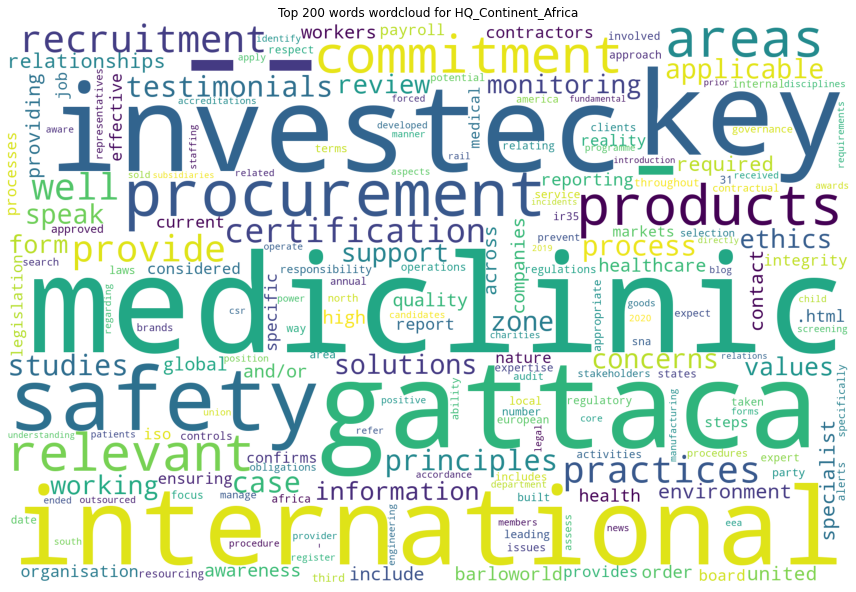

KeyboardInterrupt: 

In [191]:
%%time
# plotting wordclouds per continent
stopwords = set(list(STOPWORDS) + [char for char in string.punctuation])
MAX_WORDS = 200 
for continent in tqdm(continents, leave=False, position=0):
    freqs = []
    results = []
    for i, statement in enumerate(df[df[continent]==1]["statement_cleaned_v3"].values):
        freqs += generate_ngrams(statement, 1)    
        
    counter = Counter()
    counter.update(freqs)
    wd = WordCloud(
        width=1800, 
        height=1200,
        background_color="white", 
        max_words=MAX_WORDS)
    wd.generate_from_frequencies(frequencies=counter)
    fig, ax = plt.subplots(figsize=(12,12))
    title = f"Top {MAX_WORDS} words wordcloud for {continent}"
    ax.set_title(title)
    ax.imshow(wd)
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_PATH, "_".join(title.split())))
    plt.show()

## NGRAMS analysis on basis of years

In [20]:
df["year"] = pd.to_numeric(df["year"], errors="coerce")

In [21]:
years = df["year"].value_counts().sort_index(na_position="first")
years

2010.0     248
2011.0      26
2012.0     159
2013.0      22
2014.0      53
2015.0     219
2016.0     432
2017.0    1114
2018.0    1821
2019.0    5913
2020.0      22
2021.0       1
Name: year, dtype: int64

In [22]:
# df[df["year"]==2021]["statement"].values[0]
years.drop(2021, inplace=True) # removing garbage statement

In [23]:
%%time
ngram_freqs: Dict[int, Dict[int, TypeCounter[str]]] = {} # dict(year: dict(n:  Counter(ngram)))

futures = {}
results = {}
        
with concurrent.futures.ProcessPoolExecutor(max_workers=os.cpu_count()-10) as executor:
    for year in years.index:
        year_statements = df[df["year"]==year]["statement_cleaned_v3"].values # filter statements as per year
        for n in np.arange(1, 4)[::-1]:
            for i, statement in enumerate(year_statements):
                futures[executor.submit(
                    generate_ngrams, statement, n)] = (year, n, i)

            
    for future in concurrent.futures.as_completed(futures):
        results[futures[future]] = future.result()
        
ngram_freqs: Dict[int, Dict[int, TypeCounter[str]]] = {year: {
    n: Counter() for n in range(1, 4)[::-1]} for year in years.index}

for k, v in tqdm(results.items(), leave=False, position=0):
    year, n, _ = k
    ngram_freqs[year][n].update(v)
ngram_freqs = {
    int(year): {
        int(n): {str(k):int(v) for k, v in sorted(values.items(), key=lambda x: (-x[1], x[0]))} for n, values in ngrams.items()
    } for year, ngrams in ngram_freqs.items()}

with open("../results/ngrams/by_year.json", "w") as f:
    json.dump(ngram_freqs, f, sort_keys=False, )

CPU times: user 30.9 s, sys: 5.46 s, total: 36.3 s
Wall time: 35.3 s


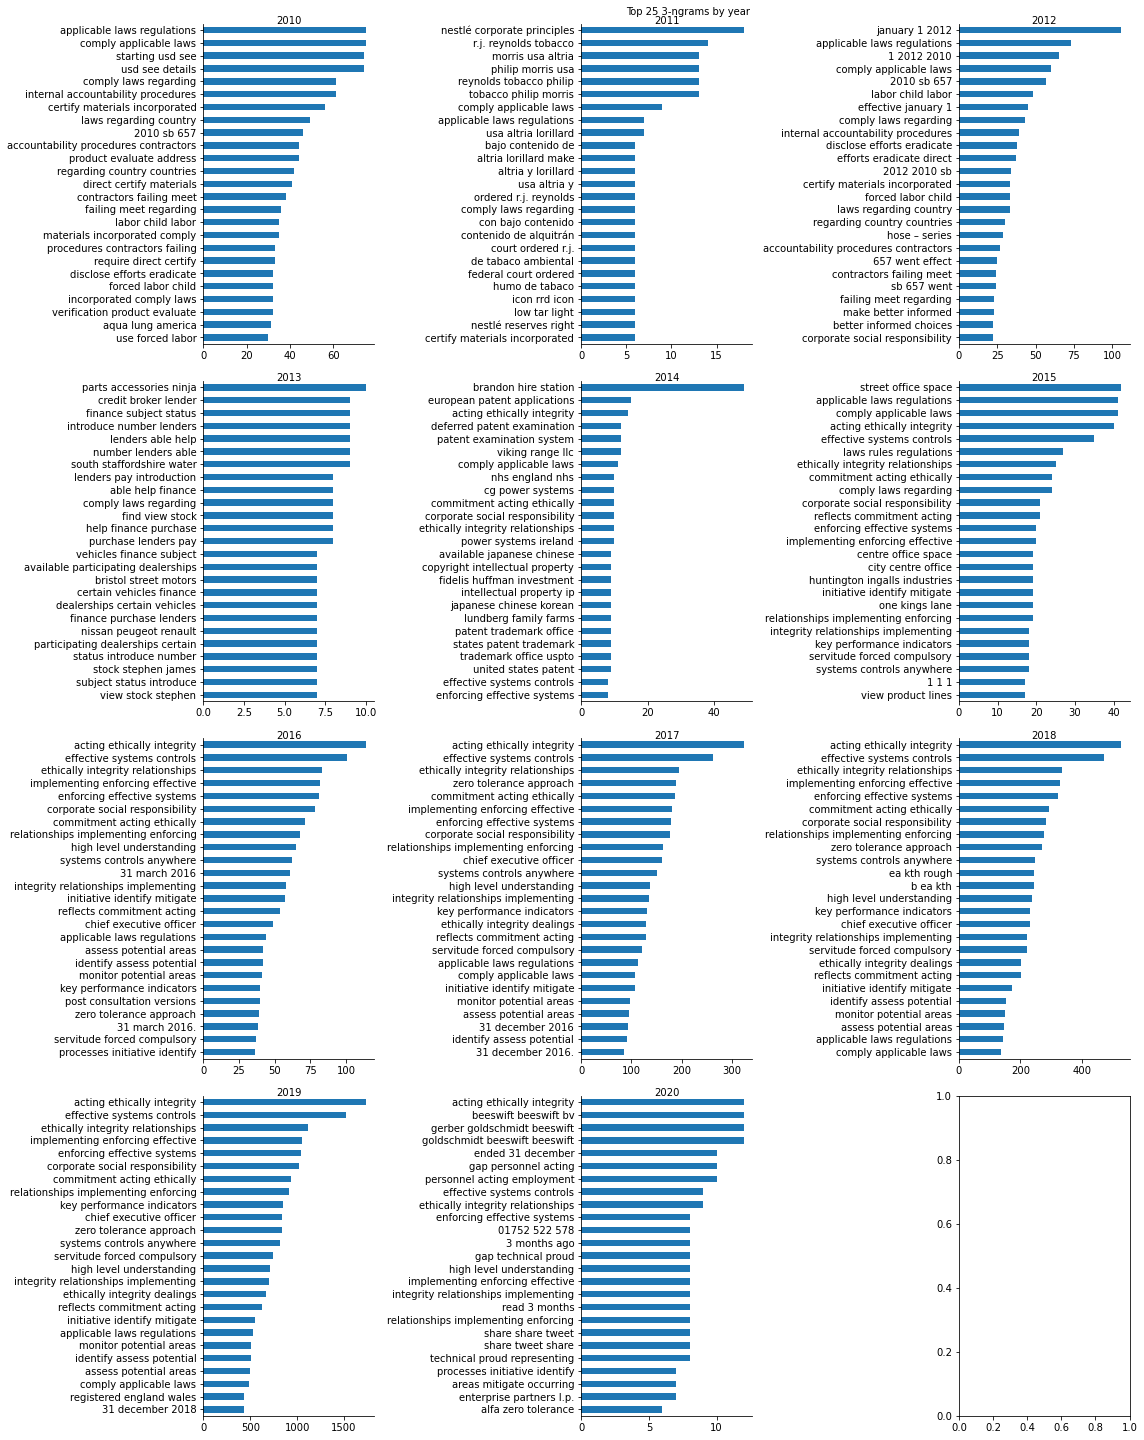

In [29]:
n = 3
top_n = 25
fig, axes = plt.subplots(
        nrows=4, ncols=3,
        figsize=(16,20),
        squeeze=False)
title = f"Top {top_n} {n}-ngrams by year"
fig.text(x=.6, y=.992, s=title, ha="center")
for year, ax in zip(years.index, axes.flatten()):
    ngrams = pd.DataFrame.from_dict(ngram_freqs[year][n], orient="index")
    ngrams.head(top_n).sort_values(0).plot.barh(ax=ax)
    ax.set_title(f"{int(year)}", y=.98, fontdict={"fontsize": 10})
    ax.get_legend().remove()
    sns.despine(ax=ax)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"{title}.jpeg"), dpi=200)

In [143]:
# ngram_freqs[2020][1]

In [120]:
weird = [statement for statement in df["statement_cleaned_v3"].values if "as" in statement.lower()]
len(weird)

11095

In [117]:
nltk.tokenize.sent_tokenize(weird[10])

['Anti-Slavery Statement | Norfolk & Suffolk | Desira Group Menu Call Us Feedback Find Us Used Search Menu Find Us Feedback Contact Numbers Home New Car Offers Fiat Nissan Citroen Peugeot Suzuki MG Jeep Alfa Romeo Abarth SsangYong NHS & Public Sector Scheme Norwich City FC Offers Young Drivers About Finance Warranty and Additional Products We Want Your Car New Cars Fiat Nissan Citroen Peugeot Suzuki MG Jeep Alfa Romeo Abarth SsangYong Warranty and Additional Products We Want Your Car Used Cars Fiat Nissan Citroen Peugeot Suzuki MG Jeep Alfa Romeo Abarth SsangYong ByDesira About Finance Lowest Price Guarantee We Want Your Car Motability Introduction Do you Qualify for Motability?',
 "Motability Adaptations Motability - FAQs Motability Checklists and Downloads Vans Citroen Vans Fiat Vans Peugeot Vans Nissan Vans Used Vans About Finance Business Business Offers Service Book an MOT or Service Online Approved Accident Repair Service Plans Service Offers Tyre Supply & fitting FAQ's Parts Tra

In [43]:
re.search("see details", weird[0])

<re.Match object; span=(1193, 1204), match='see details'>

In [39]:
ngram_freqs

{2010.0: {3: {'california transparency act': 478,
   'transparency act 2010': 276,
   'act 2010 (': 89,
   'internal accountability standards': 75,
   '* see details': 74,
   'starting usd *': 74,
   'usd * see': 74,
   'direct responsibility management': 70,
   'evaluate address risks': 70,
   'accountability standards procedures': 68,
   'applicable laws regulations': 67,
   'compliance applicable laws': 62,
   'rights reserved .': 62,
   'address risks slavery': 58,
   '( the “': 55,
   'certify materials incorporated': 55,
   'supplier ’ s': 54,
   'forced labor ,': 53,
   'comply laws regarding': 52,
   '( sb 657': 51,
   'standards procedures employees': 49,
   'country countries business': 48,
   'laws regarding country': 46,
   'meet company standards': 46,
   'product evaluate address': 45,
   'sb 657 )': 45,
   '’ s business': 45,
   'act california transparency': 44,
   'countries business .': 43,
   'transparency act disclosure': 43,
   'procedures employees contractors': 4

In [ ]:
# plotting wordclouds per year
MAX_WORDS = 200 
for year in tqdm(years.index, leave=False, position=0):
    wd = WordCloud(
        width=1800, 
        height=1200,
        background_color="white", 
        max_words=MAX_WORDS)
    wd.generate_from_frequencies(frequencies=all_freqs[1][year][1].to_dict()[0])
    fig, ax = plt.subplots(figsize=(12,12))
    title = f"Top {MAX_WORDS} words wordcloud from {int(year)} - {all_freqs[1][year][0]} statements"
    ax.set_title(title)
    ax.imshow(wd)
    ax.set_axis_off()
    plt.tight_layout()
    fp = title = f"Top {MAX_WORDS} words wordcloud from {int(year)}"
    plt.savefig(os.path.join(PLOTS_PATH, "_".join(fp.split())))
    plt.show()

In [ ]:
years

In [ ]:
fig, axes = plt.subplots(figsize=(20,10), ncols=len(years), sharey=True)
for year, ax in tqdm(zip(years.index, axes.flatten()), leave=False, position=0):
    values = df[df["year"]==year]["statement_cleaned_v2"].values
    lens = [len(statement.split()) for statement in values]
    ax.boxplot(lens)
    ax.set_title(f"{int(year)}\n {len(values)} statement/s")
    sns.despine(ax=ax)
fig.text(x=.5, y=.98, s="Distribution of number of words in statements by year", ha="center")
plt.tight_layout(pad=2)
plt.savefig(os.path.join(
    PLOTS_PATH,
    "Distribution_Number_of_Words_By_Years"),
            dpi=100)
plt.show()